In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig4_plots

import fig4_analysis as rnn
import basic_analysis as basic
import model_utils
from task import generate_batch

from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_3map/"
save_folder = f"../figures/fig4_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
    
# font sizes
title_size = 10

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

In [5]:
from matplotlib import gridspec
from scipy.special import softmax

# font sizes
title_size = 10
axis_label = 9
tick_label = 7

# map colors
c1 = 'xkcd:scarlet'
c2 = 'xkcd:bluish green'
c3 = 'k'
map_colors = [c1, c2, c3]

# rnn position input/output colors
pos_col = 'xkcd:cobalt blue'
est_col = 'xkcd:saffron'

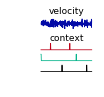

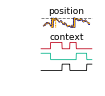

In [6]:
''' Figure 4A: model schematic '''
f, gs = fig4_plots.plot_a1(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

f, gs = fig4_plots.plot_a2(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard error of the mean:
position loss: 0.0121 +/- 0.000702
context loss: 0.00393 +/- 8.98e-05


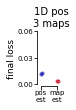

In [7]:
''' summary performance across models '''
f, ax = fig4_plots.plot_supp_1(data_folder, model_IDs)
ax.set_title('1D pos\n3 maps', fontsize=title_size, pad=5)
plt.show()

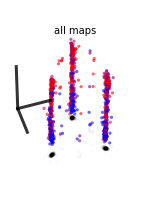

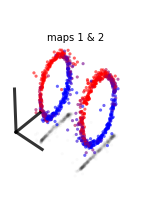

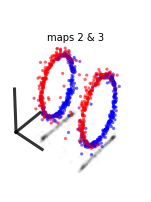

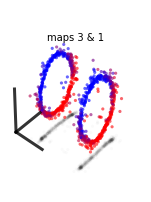

In [8]:
''' Figure 4B: aligned ring manifolds '''
f, ax = fig4_plots.plot_c(X, pos_targ)
ax.set_title('all maps',
             fontsize=title_size, pad=5)

ax.view_init(azim=160, elev=30)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

# maps 1 & 2
map_idx = ~(map_targ==2)
f, ax = fig4_plots.plot_c(X[map_idx], pos_targ[map_idx])
ax.set_title('maps 1 & 2',
             fontsize=title_size, pad=-2)
plt.show()
f.savefig(f'{save_folder}manifolds_12.png', dpi=600, bbox_inches='tight')

# maps 2 & 3
map_idx = ~(map_targ==0)
f, ax = fig4_plots.plot_c(X[map_idx], pos_targ[map_idx])
ax.set_title('maps 2 & 3',
             fontsize=title_size, pad=-2)
plt.show()
f.savefig(f'{save_folder}manifolds_23.png', dpi=600, bbox_inches='tight')

# maps 3 & 1
map_idx = ~(map_targ==1)
f, ax = fig4_plots.plot_c(X[map_idx], pos_targ[map_idx])
ax.set_title('maps 3 & 1',
             fontsize=title_size, pad=-2)
plt.show()
f.savefig(f'{save_folder}manifolds_31.png', dpi=600, bbox_inches='tight')

mean alignment = 0.6
sem misalignment = 0.0091


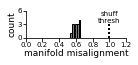

In [9]:
''' Figure 1I (or supp?): summary of ring alignment 
TODO: what is the best way to align 3 manifolds?
'''
# f, ax = fig1_plots.plot_supp_2(data_folder, model_IDs)
# f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
# plt.show()

on average, 4 PCs explain 63.28% of the variance
on average, 14 PCs explain 90.51% of the variance
on average, 2 PCs explain 48.12% of the variance within each map


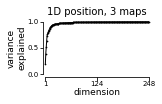

In [9]:
''' Figure 4 supplement: summary of dimensionality '''
f, axes = fig4_plots.plot_supp_3(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

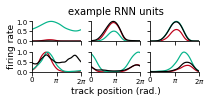

In [10]:
''' Figure 4B: example tuning '''
f, axes = fig4_plots.plot_b(X, map_targ, pos_targ)
plt.show()
f.savefig(f'{save_folder}ex_tuning.png', dpi=600, bbox_inches='tight')

In [32]:
import dim_alignment as dim

In [34]:
'''
Things to try for the 3 map model:
- angle between the position subspaces for each manifold
X angle between the remapping dimensions
- i/o relationship to pos/remapping dims (as below)
'''
# 1) Define the remapping dimensions:
# split activity by context
X0 = X[map_targ==0]
X1 = X[map_targ==1]
X2 = X[map_targ==2]

# find the remapping dimensions
remap_dim_01 = dim.remapping_dim(X0, X1)
remap_dim_12 = dim.remapping_dim(X1, X2)
remap_dim_20 = dim.remapping_dim(X2, X0)

# find the angles between them
angle_0 = dim.cosine_sim(remap_dim_01, remap_dim_20)
angle_1 = dim.cosine_sim(remap_dim_01, remap_dim_12)
angle_2 = dim.cosine_sim(remap_dim_12, remap_dim_20)
avg_angle = np.rad2deg(np.arccos(np.abs(np.mean([angle_0, angle_1, angle_2]))))

print(f'the avg angle between remapping dims is {int(avg_angle)} deg.')

the avg angle between remapping dims is 60 deg.


In [22]:
''' IN PROGRESS '''
# 2) Define the position subspaces:
n_maps = np.max(np.unique(map_targ)) + 1
pos_subspaces = []
for i in range(n_maps):
    X_map = X[map_targ==i]
    pos_map = pos_targ[map_targ==i]
    pos_subspaces.append(dim.map_subspace(X_map, pos_map))

# find the angles between them
for i in range(n_maps):
    m1 = pos_subspaces[i]
    m2 = pos_subspaces[i%n_maps]

(9549, 248)